In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import clear_output
from PIL import Image
from scipy.ndimage import gaussian_filter

from ift6758.utilities.game_utilities import filter_by_team_and_season, generate_shot_map_matrix, get_goals_per_game
from ift6758.utilities.math_utilities import subtract_and_align_matrices

sns.set()

In [2]:
plays_df = pd.read_csv("../ift6758/data/extracted/shot_goal_20161012_20210707.csv")

In [13]:
season = 20202021
team = 'Tampa Bay Lightning'
bin_size = 1

global_matrix = generate_shot_map_matrix(plays_df, bin_size=bin_size)
global_goals_per_game = get_goals_per_game(plays_df, season_filter=season)
team_matrix = generate_shot_map_matrix(team_df, bin_size=bin_size)
team_goals_per_game = get_goals_per_game(team_df, team_filter=team, season_filter=season)

print(f'Shots per game: {team_matrix.sum().sum()}')
print(
    f'Shots differential per game compared to NHL average: {team_matrix.sum().sum() - global_matrix.sum().sum()} ({(team_matrix.sum().sum() - global_matrix.sum().sum()) / global_matrix.sum().sum() * 100}%)')
print(f'Goals scored per game: {team_goals_per_game}')
print(
    f'Goals scored differential per game compared to NHL average: {team_goals_per_game - global_goals_per_game} ({(team_goals_per_game - global_goals_per_game) / global_goals_per_game * 100}%)')

difference_matrix = subtract_and_align_matrices(team_matrix, global_matrix, 0.0)
# Sort by decreasing distance from center ice so center ice appears at the bottom of the graph
difference_matrix.sort_index(ascending=False, kind='mergesort', inplace=True)

Shots per game: 28.75
Shots differential per game compared to NHL average: -1.2288790952935322 (-4.099149575897443%)
Goals scored per game: 0
Goals scored differential per game compared to NHL average: -2.888402625820569 (-100.0%)


In [14]:
df3_smooth = gaussian_filter(difference_matrix, sigma=2, order=0)
difference_matrix_smooth = pd.DataFrame(data=df3_smooth, index=difference_matrix.index,
                                        columns=difference_matrix.columns)

In [15]:
def compute_heatmap_res(season, team):
    bin_size = 1

    team_df = filter_by_team_and_season(plays_df, team, season)

    global_matrix = generate_shot_map_matrix(plays_df, bin_size=bin_size)
    global_goals_per_game = get_goals_per_game(plays_df, season_filter=season)
    team_matrix = generate_shot_map_matrix(team_df, bin_size=bin_size)
    team_goals_per_game = get_goals_per_game(team_df, team_filter=team, season_filter=season)

    difference_matrix = subtract_and_align_matrices(team_matrix, global_matrix, 0.0)
    # Sort by decreasing distance from center ice so center ice appears at the bottom of the graph
    difference_matrix.sort_index(ascending=False, kind='mergesort', inplace=True)

    ########
    smooth_data = gaussian_filter(difference_matrix, sigma=2, order=0)
    difference_matrix_smooth = pd.DataFrame(data=smooth_data, index=difference_matrix.index,
                                            columns=difference_matrix.columns)

    return difference_matrix_smooth

In [ ]:
team_list = plays_df['team'].unique()
season_list = plays_df['season'].unique()

team_season_dict = {}

for current_season in season_list:
    for current_team in team_list:
        team_season_dict[str(current_team) + str(current_season)] = compute_heatmap_res(current_season, current_team)

In [ ]:
image = Image.open("../figures/nhl_rink_offensive.png")


def display_fig(season, team):
    difference_matrix_smooth = team_season_dict[str(team) + str(season)]

    fig, ax = plt.subplots()
    im = ax.imshow(difference_matrix_smooth, extent=[-42, 42, 0, 95])

    #img = mpimg.imread('../ift6758/1hockey.jpg')
    ax.imshow(image, zorder=0, extent=[-42, 42, 0, 95], alpha=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.tight_layout()

    plt.show()

In [ ]:



season_list = plays_df['season'].unique()
season_list_out = widgets.Output()
season_selection = season_list[0]

###############################
out = widgets.Output()
###############################


team_list = plays_df['team'].unique()
team_list_out = widgets.Output()
team_selection = team_list[0]

################################

seasons_widget = widgets.Select(
    options=season_list,
    value=season_list[0],
    # rows=10,
    description='Season:',
    disabled=False
)


#display(seasons_widget, season_list_out)

def on_value_change(change):
    with out:
        #print(change['new'])
        season_selection = change['new']
        clear_output(wait=True)
        display_fig(season_selection, team_selection)


seasons_widget.observe(on_value_change, names='value')

##########


team_widget = widgets.Select(
    options=team_list,
    value=team_list[0],
    # rows=10,
    description='Team:',
    disabled=False
)


#display(team_widget, team_list_out)

def on_value_change_team(change):
    with out:
        #print(change['new'])
        team_selection = change['new']
        clear_output(wait=True)
        display_fig(season_selection, team_selection)


team_widget.observe(on_value_change_team, names='value')

widgets.HBox([widgets.VBox([seasons_widget, team_widget]), out])



In [ ]:
# Add surface trace
fig = go.Figure()

matrix = compute_heatmap_res(20162017, 'Tampa Bay Lightning')
largest_diff = max(abs(matrix.min().min()), abs(matrix.max().max()))

fig.add_trace(go.Contour(z=matrix, showscale=True, connectgaps=False,
                         colorscale=[[0, 'rgb(0,0,255)'], [0.5, 'rgb(255,255,255)'], [1,
                                                                                      'rgb(255,0,0)']],
                         x=matrix.columns, y=matrix.index, zmin=-1 * largest_diff, zmax=largest_diff))

# Update plot sizing
fig.update_layout(
    width=800,
    height=900,
    autosize=False,
    margin=dict(t=100, b=0, l=0, r=0),

)

# Update 3D scene options
fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    aspectmode="manual"
)

img = Image.open('../figures/nhl_rink_offensive.png')
fig.add_layout_image(
    dict(
        source=img,
        xref="paper", yref="paper",
        x=0.5, y=0,
        sizex=1, sizey=1,
        xanchor="center",
        yanchor="bottom",
        opacity=0.3,
    )
)
fig.show()


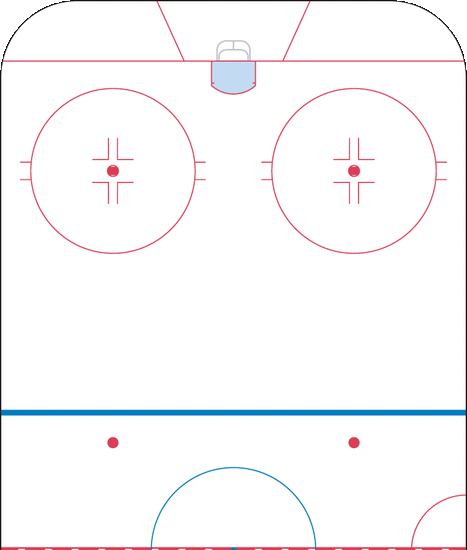

In [25]:
# How to change plot data using dropdowns
#
# This example shows how to manually add traces
# to the plot and configure the dropdown to only
# show the specific traces you allow.

fig = go.Figure()
bin_size = 5

team_list = plays_df['team'].sort_values(kind='mergesort').unique()
season_list = plays_df['season'].unique()
buttons = []
visible = [False] * len(season_list) * len(team_list)
index = 0

buttons.append(dict(label='Select a team...',
                    method='update',
                    args=[{'visible': False,
                           'showlegend': False}]))

for current_season in season_list:
    global_matrix = generate_shot_map_matrix(plays_df, bin_size=bin_size)
    for current_team in team_list:
        team_df = filter_by_team_and_season(plays_df, current_team, current_season)
        if len(team_df) > 0:
            team_matrix = generate_shot_map_matrix(team_df, bin_size=bin_size)
            team_goals_per_game = get_goals_per_game(team_df, team_filter=current_team, season_filter=current_season)

            difference_matrix = subtract_and_align_matrices(team_matrix, global_matrix, 0.0)
            # Sort by decreasing distance from center ice so center ice appears at the bottom of the graph
            difference_matrix.sort_index(ascending=False, kind='mergesort', inplace=True)

            largest_diff = max(abs(difference_matrix.min().min()), abs(difference_matrix.max().max()))

            fig.add_trace(go.Contour(z=difference_matrix, showscale=True, connectgaps=False,
                                     colorscale=[[0, 'rgb(0,0,255)'], [0.5, 'rgb(255,255,255)'], [1,
                                                                                                  'rgb(255,0,0)']],
                                     x=difference_matrix.columns, y=difference_matrix.index, zmin=-1 * largest_diff,
                                     zmax=largest_diff, line_smoothing=1.3))

            visible_copy = visible.copy()
            visible_copy[index] = True

            buttons.append(dict(label=f'{current_season} {current_team}',
                                method='update',
                                args=[{'visible': visible_copy,
                                       'showlegend': False}]))

            index += 1

# Update plot sizing
fig.update_layout(
    width=1016,
    height=900,
    autosize=True,
    margin=dict(t=100, b=0, l=0, r=0),
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=buttons,
        direction="down",
        showactive=True
    )
    ]
)

# Update 3D scene options
fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    aspectmode="auto"
)

img = Image.open('../figures/nhl_rink_offensive.png')
fig.add_layout_image(
    dict(
        source=img,
        xref="paper", yref="paper",
        x=0.5, y=0,
        sizex=1, sizey=1,
        xanchor="center",
        yanchor="bottom",
        opacity=0.3,
    )
)

fig.show()

with open('../figures/shot_map.html', 'w+') as f:
    f.write(fig.to_html())